In [1]:
import os

In [2]:
computation = 'cloud'

In [3]:
if computation == 'cloud' :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud'
  model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models'
  customer_fr_path = '/content/drive/MyDrive/uco_fraud_detector/models/customer_fr_database'
  merchant_fr_path = '/content/drive/MyDrive/uco_fraud_detector/models/merchant_fr_database'
  globalmodel_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
else :
  data_path = '../data/transaction_fraud'
  model_save_path = '../models'
  customer_fr_path = '../models/customer_fr_database'
  merchant_fr_path = '../models/merchant_fr_database'
  globalmodel_path = '../models/globalmodel'

print("searching for data path" , "found" if os.path.exists(data_path) else "not found")
print(os.listdir(data_path))

Mounted at /content/drive
searching for data path found
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model # For visualizing model architecture
from tensorflow.keras.layers import Multiply
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [5]:
np.random.seed(21)
tf.random.set_seed(21)

In [6]:
data_file = os.path.join(data_path, 'bs140513_032310.csv')

In [7]:
df = pd.read_csv(data_file)

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPUs detected: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected, using CPU")


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
with open(data_preprocess_path, 'rb') as f :
  data_preprocess = pickle.load(f)

In [10]:
df = df.replace("'" , "" , regex=True)
df = df.drop(['zipcodeOri' , 'zipMerchant'] , axis = 1)
df['account_frequency'] = df['customer'].apply(lambda x: data_preprocess['customer_frequency_rating_encoder'][x])
df['merchant_frequency'] = df['merchant'].apply(lambda x: data_preprocess['merchant_frequency_rating_encoder'][x])
df = df.rename(columns={'customer': 'account_id', 'merchant': 'merchant_id', 'step': 'time_delta'})
df = df.sort_values(['account_id', 'time_delta'])
df = df.reset_index(drop=True)
for c in data_preprocess['CATEGORICAL_COLS'] :
  df[c] = data_preprocess[c + '_label_encoder'].transform(df[c])
df[data_preprocess['NUMERICAL_COLS']] = data_preprocess['numerical_scaler'].transform(df[data_preprocess['NUMERICAL_COLS']])
df.head()

,time_delta,account_id,age,gender,merchant_id,category,amount,fraud,account_frequency,merchant_frequency
0,-1.272914,C1000148617,5,2,22,9,0.951322,0,-0.918953,-2.237926
1,-1.116216,C1000148617,5,2,15,10,-0.190302,0,-0.918953,-2.241786
2,-1.037867,C1000148617,5,2,22,9,0.164178,0,-0.918953,-2.237926
3,-1.018280,C1000148617,5,2,42,11,-0.207806,0,-0.918953,-2.233031
4,-0.998692,C1000148617,5,2,18,12,0.085544,0,-0.918953,0.765246


In [11]:
# data_preprocess = {
#     'NUMERICAL_COLS' : NUMERICAL_COLS,
#     'CATEGORICAL_COLS' : CATEGORICAL_COLS,
#     'TARGET_COL' : TARGET_COL,
#     'numerical_scaler' : scaler,
#     'age_label_encoder' : age_label_encoder,
#     'gender_label_encoder' : gender_label_encoder,
#     'merchant_id_label_encoder' : merchant_label_encoder,
#     'category_label_encoder' : category_label_encoder,
#     'customer_frequency_rating_encoder' : customer_frequency_rating_encoder,
#     'merchant_frequency_rating_encoder' : merchant_frequency_rating_encoder
# }
# saved_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
# with open(saved_data_path, 'wb') as f:
#     pickle.dump(data_preprocess, f)

In [12]:
N = 100
TOTAL_SEQUENCE_LENGTH = N + 1

# Embedding dimensions
EMBEDDING_DIM_AGE = df['age'].nunique()
EMBEDDING_DIM_GENDER = df['gender'].nunique()
EMBEDDING_DIM_MERCHANT = min(df['merchant_id'].nunique(), 100)
EMBEDDING_DIM_CATEGORY = df['category'].nunique()


In [13]:
def create_sequences_with_relevance(df, seq_length, numerical_cols, categorical_cols, target_col, N=100):
    num_features = len(numerical_cols) + len(categorical_cols)
    total_transactions = len(df)
    sequences = np.zeros((total_transactions, seq_length, num_features), dtype=np.float32)
    masks = np.zeros((total_transactions, seq_length), dtype=np.float32)  # Fraud mask
    relevance_scores = np.zeros((total_transactions, seq_length), dtype=np.float32)  # Relevance scores
    targets = df[target_col].values
    accounts = df['account_id'].unique()
    print("creating sequential data for ", len(accounts) , "accounts");
    account_counter = 0;
    for account_id, group in df.groupby('account_id'):
        group = group.sort_values('time_delta')  # Ascending order
        features = group[numerical_cols + categorical_cols].values
        fraud_labels = group[target_col].values
        indices = group.index

        for i, idx in enumerate(indices):
            current_transaction = features[i:i+1]  # Shape (1, num_features)
            current_fraud = fraud_labels[i]

            # Calculate relevance scores for all historical transactions
            hist_features = features[:i] if i > 0 else np.zeros((0, num_features))
            hist_fraud = fraud_labels[:i] if i > 0 else np.array([])
            relevance = np.zeros(i) if i > 0 else np.array([])

            if i > 0:
                for j in range(i):
                    # Similarity (example: categorical match + numerical difference)
                    cat_sim = np.mean(hist_features[j, len(numerical_cols):] == current_transaction[0, len(numerical_cols):])
                    num_diff = np.mean(np.abs(hist_features[j, :len(numerical_cols)] - current_transaction[0, :len(numerical_cols)]))
                    similarity = 0.7 * cat_sim + 0.3 * (1 - num_diff / (1e-5 + np.max(np.abs(features[:, :len(numerical_cols)]))))

                    # Temporal decay
                    time_diff = abs(group.iloc[i]['time_delta'] - group.iloc[j]['time_delta'])
                    decay = np.exp(-0.01 * time_diff)

                    # Anomaly score (e.g., based on amount deviation)
                    account_mean = np.mean(features[:i, numerical_cols.index('amount')])
                    account_std = np.std(features[:i, numerical_cols.index('amount')])
                    anomaly = 1.0 if hist_features[j, numerical_cols.index('amount')] > (account_mean + 2 * account_std) else 0.0

                    # Combined relevance score
                    relevance[j] = 0.5 * similarity + 0.3 * decay + 0.2 * anomaly

                # Select top N by relevance score
                top_indices = np.argsort(relevance)[-N:] if len(relevance) >= N else np.arange(len(relevance))
                valid_transactions = hist_features[top_indices]
                valid_fraud = hist_fraud[top_indices]

                # Build sequence
                seq = np.concatenate([current_transaction, valid_transactions[::-1]], axis=0)  # Most relevant first
                seq_mask = np.concatenate([np.array([current_fraud]), valid_fraud[::-1]], axis=0)
                seq_relevance = np.concatenate([np.array([1.0]), relevance[top_indices][::-1]], axis=0)  # 1.0 for current

                if len(seq) < seq_length:
                    padding_len = seq_length - len(seq)
                    seq = np.pad(seq, ((0, padding_len), (0, 0)), mode='constant')
                    seq_mask = np.pad(seq_mask, (0, padding_len), mode='constant')
                    seq_relevance = np.pad(seq_relevance, (0, padding_len), mode='constant')

            else:
                seq = np.pad(current_transaction, ((0, seq_length - 1), (0, 0)), mode='constant')
                seq_mask = np.pad(np.array([current_fraud]), (0, seq_length - 1), mode='constant')
                seq_relevance = np.pad(np.array([1.0]), (0, seq_length - 1), mode='constant')

            sequences[idx] = seq
            masks[idx] = seq_mask
            relevance_scores[idx] = seq_relevance
        account_counter+=1;
        if account_counter % 100 == 0 :
          print(account_counter , "accounts processed | accounts left : ", len(accounts) - account_counter)
    return sequences, masks, relevance_scores, targets

In [14]:
sequences, masks, relevance_scores, targets = create_sequences_with_relevance(df,
                                                                              TOTAL_SEQUENCE_LENGTH,
                                                                              data_preprocess['NUMERICAL_COLS'],
                                                                              data_preprocess['CATEGORICAL_COLS'],
                                                                              data_preprocess['TARGET_COL'])
print(f"Sequences shape: {sequences.shape}, Masks shape: {masks.shape}, Relevance Scores shape: {relevance_scores.shape}")

creating sequential data for  4112 accounts
100 accounts processed | accounts left :  4012
200 accounts processed | accounts left :  3912
300 accounts processed | accounts left :  3812


KeyboardInterrupt: 

In [ ]:
import pickle
relevance_seq_data = {
    'sequences': sequences,
    'masks': masks,
    'relevance_scores': relevance_scores,
    'targets': targets
}
data_save_path = 'content/drive/MyDrive/uco_fraud_detector/data/relevance_seq_data'
with open(data_save_path, 'wb') as f:
    pickle.dump(relevance_seq_data, f)

In [ ]:
assert sequences.shape == (len(df), TOTAL_SEQUENCE_LENGTH, len(NUMERICAL_COLS) + len(CATEGORICAL_COLS)), \
    f"Invalid sequences shape: {sequences.shape}"
assert targets.shape == (len(df),), f"Invalid targets shape: {targets.shape}"

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    sequences, targets, test_size=0.2, stratify=targets, random_state=21
)
print(f"Training sequences: {X_train.shape[0]}, Test sequences: {X_test.shape[0]}")
print(f"Training fraud proportion: {np.mean(y_train):.4f}, Test fraud proportion: {np.mean(y_test):.4f}")

Training sequences: 475714, Test sequences: 118929
Training fraud proportion: 0.0121, Test fraud proportion: 0.0121


In [ ]:
train_num_seq = X_train[:, :, :len(NUMERICAL_COLS)]
train_cat_seq = X_train[:, :, len(NUMERICAL_COLS):].astype(np.int32)
test_num_seq = X_test[:, :, :len(NUMERICAL_COLS)]
test_cat_seq = X_test[:, :, len(NUMERICAL_COLS):].astype(np.int32)

# Prepare inputs
X_train = {
    'numerical_input': train_num_seq,
    'age_input': train_cat_seq[:, :, 0],
    'gender_input': train_cat_seq[:, :, 1],
    'merchant_input': train_cat_seq[:, :, 2],
    'category_input': train_cat_seq[:, :, 3]
}
X_test = {
    'numerical_input': test_num_seq,
    'age_input': test_cat_seq[:, :, 0],
    'gender_input': test_cat_seq[:, :, 1],
    'merchant_input': test_cat_seq[:, :, 2],
    'category_input': test_cat_seq[:, :, 3]
}

In [ ]:
num_samples_train = X_train['numerical_input'].shape[0]
num_samples_test = X_test['numerical_input'].shape[0]
for key in X_train:
    assert X_train[key].shape[0] == num_samples_train, f"Mismatched train shape for {key}: {X_train[key].shape}"
    assert X_train[key].shape[1] == TOTAL_SEQUENCE_LENGTH, f"Invalid sequence length for {key}: {X_train[key].shape}"
for key in X_test:
    assert X_test[key].shape[0] == num_samples_test, f"Mismatched test shape for {key}: {X_test[key].shape}"
    assert X_test[key].shape[1] == TOTAL_SEQUENCE_LENGTH, f"Invalid sequence length for {key}: {X_test[key].shape}"
print("Input shapes validated successfully")

Input shapes validated successfully


In [ ]:
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.2, name='multi_head_attention')
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4), name='dense_1'),
            layers.Dense(embed_dim, kernel_regularizer=keras.regularizers.l2(1e-4), name='dense_2')
        ], name='feed_forward_network')
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6, name='layer_norm_1')
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6, name='layer_norm_2')
        self.dropout1 = layers.Dropout(rate, name='dropout_1')
        self.dropout2 = layers.Dropout(rate, name='dropout_2')

    def call(self, inputs, training, mask=None):
        # Assuming inputs is the combined tensor after embedding and concatenation
        seq_len = tf.shape(inputs)[1]
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        causal_mask = tf.cast(causal_mask, tf.bool)

        # Get the mask from the input tensor (assuming masking was applied before)
        input_mask = self._compute_mask(inputs, mask=mask)
        if input_mask is not None:
            # Expand mask to be compatible with attention mask shape
            input_mask = tf.cast(input_mask, causal_mask.dtype)
            causal_mask = causal_mask & input_mask[:, tf.newaxis, :]

        norm1 = self.layernorm1(inputs)
        attn_output = self.att(norm1, norm1, attention_mask=causal_mask)
        current_transaction_bias = tf.zeros_like(attn_output)
        current_transaction_bias = current_transaction_bias[:, 0:1, :] + 0.1
        attn_output = attn_output + current_transaction_bias
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        norm2 = self.layernorm2(out1)
        ffn_output = self.ffn(norm2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    def _compute_mask(self, inputs, mask=None):
        # Compute mask based on the input tensor's mask if available
        return tf.keras.backend.get_value(inputs._keras_mask) if hasattr(inputs, '_keras_mask') else None

In [ ]:
def create_2block_transformer_model():
    numerical_input = layers.Input(shape=(TOTAL_SEQUENCE_LENGTH, len(NUMERICAL_COLS)), name='numerical_input')
    age_input = layers.Input(shape=(TOTAL_SEQUENCE_LENGTH,), name='age_input', dtype=tf.int32)
    gender_input = layers.Input(shape=(TOTAL_SEQUENCE_LENGTH,), name='gender_input', dtype=tf.int32)
    merchant_input = layers.Input(shape=(TOTAL_SEQUENCE_LENGTH,), name='merchant_input', dtype=tf.int32)
    category_input = layers.Input(shape=(TOTAL_SEQUENCE_LENGTH,), name='category_input', dtype=tf.int32)

    # Numerical input with masking
    numerical_masked = layers.Masking(mask_value=0.0)(numerical_input)

    # Embedding layers for categorical features
    age_embedding = layers.Embedding(EMBEDDING_DIM_AGE, EMBEDDING_DIM_AGE, mask_zero=True, name='age_embedding')(age_input)
    age_embedding = age_embedding + layers.Dense(EMBEDDING_DIM_AGE, use_bias=False)(age_embedding)
    gender_embedding = layers.Embedding(EMBEDDING_DIM_GENDER, EMBEDDING_DIM_GENDER, mask_zero=True, name='gender_embedding')(gender_input)
    gender_embedding = gender_embedding + layers.Dense(EMBEDDING_DIM_GENDER, use_bias=False)(gender_embedding)
    merchant_embedding = layers.Embedding(EMBEDDING_DIM_MERCHANT, EMBEDDING_DIM_MERCHANT, mask_zero=True, name='merchant_embedding')(merchant_input)
    merchant_embedding = merchant_embedding + layers.Dense(EMBEDDING_DIM_MERCHANT, use_bias=False)(merchant_embedding)
    category_embedding = layers.Embedding(EMBEDDING_DIM_CATEGORY, EMBEDDING_DIM_CATEGORY, mask_zero=True, name='category_embedding')(category_input)
    category_embedding = category_embedding + layers.Dense(EMBEDDING_DIM_CATEGORY, use_bias=False)(category_embedding)

    # Concatenate all features
    combined = layers.Concatenate(axis=-1)([numerical_masked, age_embedding, gender_embedding,
                                            merchant_embedding, category_embedding])

    # Add positional encoding
    total_embed_dim = combined.shape[-1] # Get the actual embedding dimension after concatenation
    pos_encoding = layers.Embedding(TOTAL_SEQUENCE_LENGTH, total_embed_dim)(tf.range(TOTAL_SEQUENCE_LENGTH))
    pos_encoding = tf.expand_dims(pos_encoding, 0)
    combined = combined + pos_encoding


    transformer_output = combined
    for i in range(2):
        # Pass the combined tensor to the TransformerBlock
        transformer_block = TransformerBlock(embed_dim=total_embed_dim, num_heads=8, ff_dim=256, name=f'transformer_block_{i+1}')
        transformer_output = transformer_block(transformer_output, training=True) # Pass combined tensor here

    pooled_output = layers.GlobalAveragePooling1D()(transformer_output)

    dense = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4), name='final_dense')(pooled_output)
    dropout = layers.Dropout(0.4, name='final_dropout')(dense)
    output = layers.Dense(1, activation='sigmoid', name='fraud_prediction', dtype='float32')(dropout)

    model = keras.Model(inputs=[numerical_input, age_input, gender_input, merchant_input, category_input],
                        outputs=output)
    return model

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
@tf.keras.utils.register_keras_serializable()
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, save_path, **kwargs):
        super(MetricsCallback, self).__init__(**kwargs)
        self.validation_data = validation_data
        self.save_path = save_path
        self.best_f1 = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_prob = self.model.predict(X_val, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        f1 = f1_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        print(f" - val_f1_score: {f1:.4f}, val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_roc_auc: {roc_auc:.4f}")

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.model.save(self.save_path, overwrite=True)
            print(f"Saved model with best val_f1_score: {f1:.4f} at {self.save_path}")

    def get_config(self):
        config = super(MetricsCallback, self).get_config()
        config.update({
            'save_path': self.save_path
        })
        return config


In [ ]:
model = create_2block_transformer_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy' ,
                       tf.keras.metrics.AUC(name = 'auc'),
                       tf.keras.metrics.Precision(name = 'precision'),
                       tf.keras.metrics.Recall(name = 'recall')])

In [ ]:
model.summary()
plot_model(model, to_file='upgrade_nultih_attn_model.png', show_shapes=True, show_layer_names=True)
print('Model plot saved as upgrade_nultih_attn_model.png')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ age_input           │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_input        │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merchant_input      │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_embedding       │ (None, 101, 8)    │         64 │ age_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_embedding    │ (None, 101, 4)    │         16 │ gender_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merchant_embedding  │ (None, 101, 50)   │      2,500 │ merchant_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_embedding  │ (None, 101, 15)   │        225 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 101, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 101, 8)    │         64 │ age_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 101, 4)    │         16 │ gender_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 101, 50)   │      2,500 │ merchant_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 101, 15)   │        225 │ category_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 101, 4)    │          0 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 101, 8)    │          0 │ age_embedding[0]… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 101, 4)    │          0 │ gender_embedding… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 101, 50)   │          0 │ merchant_embeddi… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 101, 15)   │          0 │ category_embeddi… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 152,983 (597.59 KB)

 Trainable params: 152,983 (597.59 KB)

 Non-trainable params: 0 (0.00 B)

Model plot saved as upgrade_nultih_attn_model.png


In [ ]:
BATCH_SIZE = 32

# Ensure consistent data types for dataset creation
numerical_input_dtype = tf.float32
categorical_input_dtype = tf.int32
target_dtype = np.float32 # Corrected to use np.float32

# Reshape targets to be 2D
y_train_reshaped = y_train[:, np.newaxis].astype(target_dtype)
y_test_reshaped = y_test[:, np.newaxis].astype(target_dtype)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'numerical_input': tf.cast(X_train['numerical_input'], numerical_input_dtype),
        'age_input': tf.cast(X_train['age_input'], categorical_input_dtype),
        'gender_input': tf.cast(X_train['gender_input'], categorical_input_dtype),
        'merchant_input': tf.cast(X_train['merchant_input'], categorical_input_dtype),
        'category_input': tf.cast(X_train['category_input'], categorical_input_dtype)
    },
    y_train_reshaped
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'numerical_input': tf.cast(X_test['numerical_input'], numerical_input_dtype),
        'age_input': tf.cast(X_test['age_input'], categorical_input_dtype),
        'gender_input': tf.cast(X_test['gender_input'], categorical_input_dtype),
        'merchant_input': tf.cast(X_test['merchant_input'], categorical_input_dtype),
        'category_input': tf.cast(X_test['category_input'], categorical_input_dtype)
    },
    y_test_reshaped
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
best_model_path = os.path.join(model_save_path, 'best_2block_transformer_n100_model_1.keras')
callbacks = [
    MetricsCallback(validation_data=(X_test, y_test), save_path=best_model_path)
]


In [ ]:
# history = model.fit(
#     train_dataset,
#     epochs=15,
#     validation_data=test_dataset,
#     callbacks=callbacks,
#     verbose=1
# )

In [ ]:
best_model_path = os.path.join(model_save_path, 'best_2block_transformer_n100_model_1.keras')
with keras.utils.custom_object_scope({'TransformerBlock': TransformerBlock}):
    model = keras.models.load_model(best_model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
result = model.evaluate(test_dataset, verbose=0 , return_dict = True)
print('test resulf \n',result)

test resulf 
 {'accuracy': 0.9970991015434265, 'auc': 0.9928206205368042, 'loss': 0.009131207130849361, 'precision': 0.9028697609901428, 'recall': 0.8520833253860474}


3717/3717 ━━━━━━━━━━━━━━━━━━━━ 296s 79ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117489
           1       0.90      0.85      0.88      1440

    accuracy                           1.00    118929
   macro avg       0.95      0.93      0.94    118929
weighted avg       1.00      1.00      1.00    118929



<Axes: >

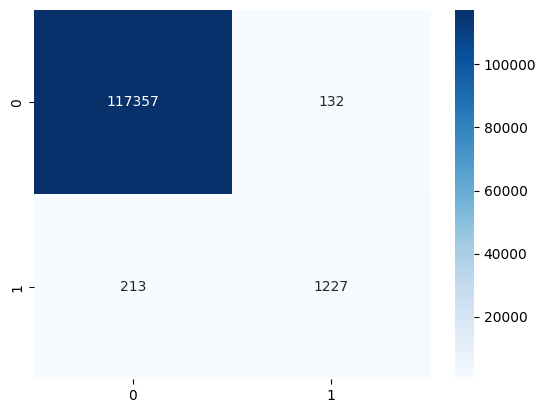

In [ ]:
# Compute final F1-score
y_pred_prob = model.predict(test_dataset, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
print(classification_report(y_test , y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [ ]:
y_pred_prob = model.predict(test_dataset, verbose=0)
thresholds = np.arange(0.2, 0.7, 0.1)
best_f1 = -float('inf')
best_threshold = 0.5
best_metrics = {}

for threshold in thresholds:
    y_pred = (y_pred_prob > threshold).astype(int).flatten()
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"Threshold {threshold:.1f}: F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {'f1': f1, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc}

print(f"Best Threshold: {best_threshold:.1f}")
print(f"Final Test F1-Score: {best_metrics['f1']:.4f}")
print(f"Final Test Precision: {best_metrics['precision']:.4f}")
print(f"Final Test Recall: {best_metrics['recall']:.4f}")
print(f"Final Test ROC-AUC: {best_metrics['roc_auc']:.4f}")

Threshold 0.2: F1-Score: 0.8465, Precision: 0.7990, Recall: 0.9000, ROC-AUC: 0.9989
Threshold 0.3: F1-Score: 0.8641, Precision: 0.8457, Recall: 0.8833, ROC-AUC: 0.9989
Threshold 0.4: F1-Score: 0.8722, Precision: 0.8799, Recall: 0.8646, ROC-AUC: 0.9989
Threshold 0.5: F1-Score: 0.8767, Precision: 0.9029, Recall: 0.8521, ROC-AUC: 0.9989
Threshold 0.6: F1-Score: 0.8768, Precision: 0.9167, Recall: 0.8403, ROC-AUC: 0.9989
Best Threshold: 0.6
Final Test F1-Score: 0.8768
Final Test Precision: 0.9167
Final Test Recall: 0.8403
Final Test ROC-AUC: 0.9989
